# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [8]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

Load the `cardiac_ml_tools` module.

In [9]:
%run cardiac_ml_tools.py

## Load the dataset

In [15]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../Datasets/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[1][0], file_pairs[1][1]))


# How much data is there in each file pair ?
data_from_file1 = np.load(file_pairs[1][0])
data_from_file2 = np.load(file_pairs[1][1])
print(data_from_file1.shape)
print(data_from_file2.shape)

# This means, each data pair contains one specific patients data/one specific data sample.
# How can we load this ? This data is obviously too big


Number of file pairs: 16117
Example of file pair:
../Datasets/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
../Datasets/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
(500, 10)
(500, 75)


Case 213 : ../Datasets/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


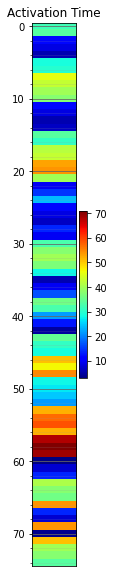

In [12]:
# Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


## Task 3: Learning the mapping from the 12-lead ECG to the activation map

Case 213 : ../Datasets/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy
Case 213 : ../Datasets/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


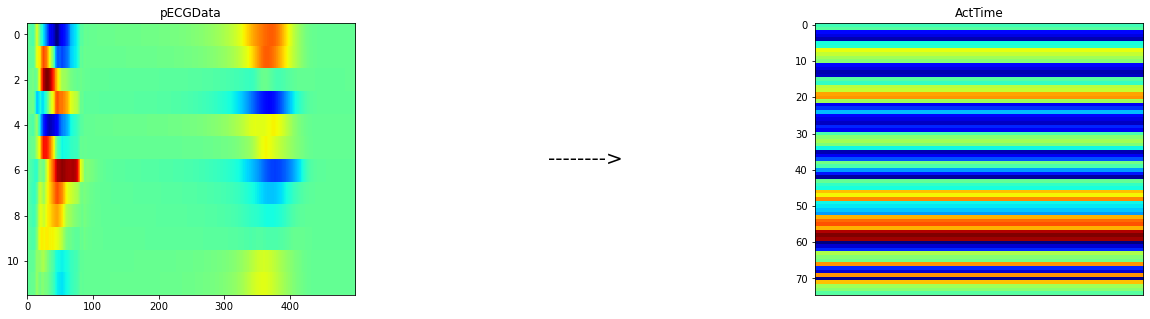

In [13]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

In [ ]:
# What can we say about the data ?

# The activation times for different patients lies between 0 and 100 milliseconds
# The \min_{j} V_ij for j \in [0,500] detects the activation time for each 

# What is our objective ?


# What are we going to use ?

In [80]:
# How is the model for the RNN going to be

# We need to define the input shape
# Then we need to define the output shape
# Then we need to define the model!
from torch import nn
import torch
from torch import optim

class RNN(nn.Module):
    def __init__(self, inpDim, outDim):
        super().__init__()
        self.EcgStack = nn.Sequential(
            nn.Linear(inpDim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, inpDim),
            nn.ReLU(),
            nn.Softmax()
        )
        self.VoltageStack = nn.Sequential(
            nn.Linear(inpDim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, outDim),
            nn.ReLU(),
            nn.Softmax()
        )
        
    def forward(self, Vinp, EcgInp):
        # Let's have input aggregated for both the Voltage
        
        # If train vs if not-train
        VoltageOutput = []
        EcgOutput = []
        if self.train:
            for i in range(500):
                if i != 499:
                    EcgOutput.append(self.EcgStack(EcgInp[i,:]))

                VoltageOutput.append(self.VoltageStack(EcgInp[i, :]))
                
        if not self.train:

            # Just take the first step
            for i in range(500):
                EcgOutput.append(EcgInp)
                EcgOp = self.ecgStack(EcgInp)
                EcgOutput.append(EcgOp)
                EcgInp = EcgOutput
                VOp = self.VoltageStack(Vinp)
                VoltageOutput.append(Vinp)
                VoltageOuput.append(VOp)
                Vinp = VOp
                
        
        return torch.stack(VoltageOutput, axis=0), torch.stack(EcgOutput, axis=0)
    
    

In [87]:
# Let's see if the network works
model = RNN(inpDim = 12, outDim=75)
model.train()
Voltage, ecg = model(torch.from_numpy(get_standard_leads(data_from_file1)).float(), torch.from_numpy(get_standard_leads(data_from_file2)).float())

# Alright, if it works, create the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
# Now let's start training the stuff


# Iterate over the data
for i, file_pair in enumerate(file_pairs):
    torchEcg, torchVoltage = torch.from_numpy(get_standard_leads(np.load(file_pair[0]))), torch.from_numpy(np.load(file_pair[1]))
    torchEcg, torchVoltage = torch.nn.functional.normalize(torchEcg, p=2., dim=1),torch.nn.functional.normalize(torchVoltage, p=2., dim=1)
    torchNVoltage, torchNEcg = model(torchVoltage.float(), torchEcg.float())
    loss = torch.mean(torch.square(torchNEcg - torchEcg[1:,:])) + torch.mean(torch.square(torchNVoltage - torchVoltage))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:    
        print('Loss: '+str(loss.item()) +' iterate: ' +str(i))

    
    
    

Loss: 0.08845277595707234 iterate: 0
Loss: 0.07517556430212495 iterate: 100
Loss: 0.09042922471771397 iterate: 200
Loss: 0.09440226617760492 iterate: 300
Loss: 0.06359421707410025 iterate: 400
Loss: 0.10571583811170693 iterate: 500
Loss: 0.11238685615413352 iterate: 600
Loss: 0.07942703758449751 iterate: 700
Loss: 0.0769221261355508 iterate: 800
Loss: 0.10001780498366714 iterate: 900
Loss: 0.06275459586859529 iterate: 1000
Loss: 0.07155699970096038 iterate: 1100
Loss: 0.09953470795984694 iterate: 1200
Loss: 0.09205355033248941 iterate: 1300
Loss: 0.07933707495619671 iterate: 1400
Loss: 0.08267256424651896 iterate: 1500
Loss: 0.10227523684725381 iterate: 1600
Loss: 0.09874344799126589 iterate: 1700
Loss: 0.08675161388657301 iterate: 1800
Loss: 0.1028653236618844 iterate: 1900
Loss: 0.08167064181666492 iterate: 2000
Loss: 0.08320432530417796 iterate: 2100
Loss: 0.07933705183179963 iterate: 2200
Loss: 0.08301824981578626 iterate: 2300
Loss: 0.08597309000661787 iterate: 2400
Loss: 0.067202